# Pairs Trading Backtest Notebook

This comprehensive notebook supports both StaticFit and SlidingFit.
It automatically adapts its analysis and visualization based on the strategy specified in the configuration file.

## Key Features:

1. **Configuration-Driven**: Loads strategy and parameters from HJSON configuration files
2. **Dual Model Support**: Works with both StaticFit and SlidingFit
3. **Adaptive Visualization**: Different visualizations based on selected strategy
4. **Comprehensive Analysis**: Deep analysis of trading pairs and dis-equilibrium
5. **Interactive Configuration**: Easy parameter adjustment and re-running

## Usage:

1. **Configure Parameters**: Set CONFIG_FILE, SYMBOL_A, SYMBOL_B, and TRADING_DATE
2. **Run Analysis**: Execute cells step by step
3. **View Results**: Comprehensive visualizations and trading signals
4. **Experiment**: Modify parameters and re-run for different scenarios



# Settings

In [1]:
# Trading Parameters Configuration
# Specify your configuration file, trading symbols and date here

# Configuration file selection
global CONFIG_FILE
global SYMBOL_A
global SYMBOL_B
global TRADING_DATE
global TRD_DATE
global PT_BT_CONFIG
global DATA_FILE
global FIT_METHOD_TYPE
global pair
global pair_trades
global bt_result

# ================================ E Q U I T Y ================================
# CONFIG_FILE = "equity"  # Options: "equity", "crypto", or custom filename (without .cfg extension)

# # Date for data file selection (format: YYYYMMDD)
# TRADING_DATE = "20250604"  # Change this to your desired date

# # Trading pair symbols
# SYMBOL_A = "COIN"   # Change this to your desired symbol A
# SYMBOL_B = "MSTR"   # Change this to your desired symbol B
# ================================ E Q U I T Y ================================

# ================================ C R Y P T O ================================
CONFIG_FILE = "crypto"  # Options: "equity", "crypto", or custom filename (without .cfg extension)

# Date for data file selection (format: YYYYMMDD)
TRADING_DATE = "20250605"  # Change this to your desired date

# Trading pair symbols
SYMBOL_A = "BTC-USDT"   # Change this to your desired symbol A
SYMBOL_B = "ETH-USDT"   # Change this to your desired symbol B
# ================================ C R Y P T O ================================

FIT_METHOD_TYPE = "SlidingFit"
TRD_DATE = f"{TRADING_DATE[0:4]}-{TRADING_DATE[4:6]}-{TRADING_DATE[6:8]}"


# Setup and Configuration

## Code Setup

In [2]:
def setup() -> None:
    import sys
    import os
    sys.path.append('/home/oleg/develop/pairs_trading/lib')
    sys.path.append('/home/coder/pairs_trading/lib')

    import pandas as pd
    import numpy as np
    import importlib
    from typing import Dict, List, Optional
    from IPython.display import clear_output

    # Import our modules
    from pt_trading.sliding_fit import SlidingFit
    from pt_trading.fit_method import PairState
    from pt_trading.trading_pair import TradingPair
    # from pt_trading.results import BacktestResult

    pd.set_option('display.width', 400)
    pd.set_option('display.max_colwidth', None)
    pd.set_option('display.max_columns', None)

    print("Setup complete!")


## Load Configuration


In [3]:
# Load Configuration from Configuration Files using HJSON
from typing import Dict, Optional
import hjson
import os
import importlib


def load_config_from_file() -> Optional[Dict]:
    """Load configuration from configuration files using HJSON"""
    config_file = f"../../configuration/{CONFIG_FILE}.cfg"
    
    try:
        with open(config_file, 'r') as f:
            # HJSON handles comments, trailing commas, and other human-friendly features
            config = hjson.load(f)
        
        # Convert relative paths to absolute paths from notebook perspective
        if 'data_directory' in config:
            data_dir = config['data_directory']
            if data_dir.startswith('./'):
                # Convert relative path to absolute path from notebook's perspective
                config['data_directory'] = os.path.abspath(f"../../{data_dir[2:]}")
        
        return config
        
    except FileNotFoundError:
        print(f"Configuration file not found: {config_file}")
        return None
    except hjson.HjsonDecodeError as e:
        print(f"HJSON parsing error in {config_file}: {e}")
        return None
    except Exception as e:
        print(f"Unexpected error loading config from {config_file}: {e}")
        return None

def instantiate_fit_method_from_config(config: Dict):
    """Dynamically instantiate strategy from config"""
    fit_method_class_name = config.get("fit_method_class", None)
    if fit_method_class_name is None or fit_method_class_name[-10:] != "SlidingFit":
        raise ValueError(f"Only SidingFit is supported, got {fit_method_class_name}")
    
    try:
        # Split module and class name
        if '.' in fit_method_class_name:
            module_name, class_name = fit_method_class_name.rsplit('.', 1)
        else:
            module_name = "fit_methods"
            class_name = fit_method_class_name
        
        # Import module and get class
        module = importlib.import_module(module_name)
        fit_method_class = getattr(module, class_name)
        
        print("Load configuration SUCCESS")
        # Instantiate strategy
        return fit_method_class()
    except ValueError as e:
        print(f"Error instantiating strategy {fit_method_class_name}: {e}")
        raise Exception(f"Error instantiating strategy {fit_method_class_name}: {e}") from e
        
    except Exception as e:
        print(f"Error instantiating strategy {fit_method_class_name}: {e}")
        raise Exception(f"Error instantiating strategy {fit_method_class_name}: {e}") from e




## Print Configuration

In [4]:
def print_config() -> None:
    global PT_BT_CONFIG
    global CONFIG_FILE
    global SYMBOL_A
    global SYMBOL_B
    global TRD_DATE
    global DATA_FILE
    global FIT_MODEL

    print(f"Trading Parameters:")
    print(f"  Configuration: {CONFIG_FILE}")
    print(f"  Symbol A: {SYMBOL_A}")
    print(f"  Symbol B: {SYMBOL_B}")
    print(f"  Trading Date: {TRD_DATE}")

    # Load the specified configuration
    print(f"\nLoading {CONFIG_FILE} configuration using HJSON...")

    CONFIG = load_config_from_file()
    assert CONFIG is not None
    PT_BT_CONFIG = dict(CONFIG)

    if PT_BT_CONFIG:
        print(f"✓ Successfully loaded {PT_BT_CONFIG['security_type']} configuration")
        print(f"  Data directory: {PT_BT_CONFIG['data_directory']}")
        print(f"  Database table: {PT_BT_CONFIG['db_table_name']}")
        print(f"  Exchange: {PT_BT_CONFIG['exchange_id']}")
        print(f"  Training window: {PT_BT_CONFIG['training_minutes']} minutes")
        print(f"  Open threshold: {PT_BT_CONFIG['dis-equilibrium_open_trshld']}")
        print(f"  Close threshold: {PT_BT_CONFIG['dis-equilibrium_close_trshld']}")
        
        # Instantiate strategy from config
        FIT_MODEL = instantiate_fit_method_from_config(PT_BT_CONFIG)
        print(f"  Fit Method: {type(FIT_MODEL).__name__}")
        
        # Automatically construct data file name based on date and config type
        DATA_FILE = f"{TRADING_DATE}.mktdata.ohlcv.db"

        # Update CONFIG with the specific data file and instruments
        PT_BT_CONFIG["datafiles"] = [DATA_FILE]
        PT_BT_CONFIG["instruments"] = [SYMBOL_A, SYMBOL_B]
        
        print(f"\nData Configuration:")
        print(f"  Data File: {DATA_FILE}")
        print(f"  Security Type: {PT_BT_CONFIG['security_type']}")
        
        # Verify data file exists
        data_file_path = f"{PT_BT_CONFIG['data_directory']}/{DATA_FILE}"
        if os.path.exists(data_file_path):
            print(f"  ✓ Data file found: {data_file_path}")
        else:
            print(f"  ⚠ Data file not found: {data_file_path}")
            print(f"    Please check if the date and file exist in the data directory")
            
            # List available files in the data directory
            try:
                data_dir = PT_BT_CONFIG['data_directory']
                if os.path.exists(data_dir):
                    available_files = [f for f in os.listdir(data_dir) if f.endswith('.db')]
                    print(f"    Available files in {data_dir}:")
                    for file in sorted(available_files)[:5]:  # Show first 5 files
                        print(f"      - {file}")
                    if len(available_files) > 5:
                        print(f"      ... and {len(available_files)-5} more files")
            except Exception as e:
                print(f"    Could not list files in data directory: {e}")
    else:
        print("⚠ Failed to load configuration. Please check the configuration file.")


## Prepare Market Data

In [5]:
def prepare_market_data() -> None:    # Load market data
    global PT_BT_CONFIG
    global DATA_FILE
    global SYMBOL_A
    global SYMBOL_B
    global pair

    import pandas as pd
    from tools.data_loader import load_market_data
    from pt_trading.trading_pair import TradingPair


    datafile_path = f"{PT_BT_CONFIG['data_directory']}/{DATA_FILE}"
    print(f"Loading data from: {datafile_path}")

    market_data_df = load_market_data(datafile_path, config=PT_BT_CONFIG)

    print(f"Loaded {len(market_data_df)} rows of market data")
    print(f"Symbols in data: {market_data_df['symbol'].unique()}")
    print(f"Time range: {market_data_df['tstamp'].min()} to {market_data_df['tstamp'].max()}")

    # Create trading pair
    pair = TradingPair(
        config=PT_BT_CONFIG,
        market_data=market_data_df,
        symbol_a=SYMBOL_A,
        symbol_b=SYMBOL_B,
        price_column=PT_BT_CONFIG["price_column"]
    )

    print(f"\nCreated trading pair: {pair}")
    print(f"Market data shape: {pair.market_data_.shape}")
    print(f"Column names: {pair.colnames()}")

    # Display sample data
    print(f"\nSample data:")
    # with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    #     print(pair.market_data_)
    display(pair.market_data_.head())

    display(pair.market_data_.tail())
# prepare_market_data()

## Print Strategy Specifics


In [6]:
global FIT_MODEL
global PT_BT_CONFIG
global pair

def print_strategy_specifics() -> None:     # Determine analysis approach based on strategy type
    print(f"Analysis for SlidingFit ...")

    print("\n=== SLIDING FIT FIT_MODEL ANALYSIS ===")
    print("This strategy:")
    print("  - Re-fits cointegration model using sliding window")
    print("  - Adapts to changing market conditions")
    print("  - Dynamic parameter updates every minute")

    # Calculate maximum possible iterations for sliding window
    training_minutes = PT_BT_CONFIG["training_minutes"]
    max_iterations = len(pair.market_data_) - training_minutes
    print(f"\nSliding window analysis parameters:")
    print(f"  Training window size: {training_minutes} minutes")
    print(f"  Maximum iterations: {max_iterations}")
    print(f"  Total analysis time: ~{max_iterations} minutes")

    print(f"\nStrategy Configuration:")
    print(f"  Open threshold: {PT_BT_CONFIG['dis-equilibrium_open_trshld']}")
    print(f"  Close threshold: {PT_BT_CONFIG['dis-equilibrium_close_trshld']}")
    print(f"  Training minutes: {PT_BT_CONFIG['training_minutes']}")
    print(f"  Funding per pair: ${PT_BT_CONFIG['funding_per_pair']}")


## Visualize Raw Price Data


In [7]:
def visualize_prices() -> None:
    # Plot raw price data
    global price_data
    
    import matplotlib.pyplot as plt
    # Set plotting style
    import seaborn as sns

    plt.style.use('seaborn-v0_8')
    sns.set_palette("husl")
    plt.rcParams['figure.figsize'] = (15, 10)

    # Get column names for the trading pair
    colname_a, colname_b = pair.colnames()
    price_data = pair.market_data_.copy()

    # # 1. Price data - separate plots for each symbol
    # colname_a, colname_b = pair.colnames()
    # price_data = pair.market_data_.copy()

    # Create separate subplots for better visibility
    fig_price, price_axes = plt.subplots(2, 1, figsize=(18, 10))

    # Plot SYMBOL_A
    price_axes[0].plot(price_data['tstamp'], price_data[colname_a], alpha=0.7, 
                        label=f'{SYMBOL_A}', linewidth=1, color='blue')
    price_axes[0].set_title(f'{SYMBOL_A} Price Data ({TRD_DATE})')
    price_axes[0].set_ylabel(f'{SYMBOL_A} Price')
    price_axes[0].legend()
    price_axes[0].grid(True)

    # Plot SYMBOL_B
    price_axes[1].plot(price_data['tstamp'], price_data[colname_b], alpha=0.7, 
                        label=f'{SYMBOL_B}', linewidth=1, color='red')
    price_axes[1].set_title(f'{SYMBOL_B} Price Data ({TRD_DATE})')
    price_axes[1].set_ylabel(f'{SYMBOL_B} Price')
    price_axes[1].set_xlabel('Time')
    price_axes[1].legend()
    price_axes[1].grid(True)

    plt.tight_layout()
    plt.show()
        

    # Plot individual prices
    fig, axes = plt.subplots(2, 1, figsize=(18, 12))

    # Normalized prices for comparison
    norm_a = price_data[colname_a] / price_data[colname_a].iloc[0]
    norm_b = price_data[colname_b] / price_data[colname_b].iloc[0]

    axes[0].plot(price_data['tstamp'], norm_a, label=f'{SYMBOL_A} (normalized)', alpha=0.8, linewidth=1)
    axes[0].plot(price_data['tstamp'], norm_b, label=f'{SYMBOL_B} (normalized)', alpha=0.8, linewidth=1)
    axes[0].set_title(f'Normalized Price Comparison (Base = 1.0)  ({TRD_DATE})')
    axes[0].set_ylabel('Normalized Price')
    axes[0].legend()
    axes[0].grid(True)

    # Price ratio
    price_ratio = price_data[colname_a] / price_data[colname_b]
    axes[1].plot(price_data['tstamp'], price_ratio, label=f'{SYMBOL_A}/{SYMBOL_B} Ratio', color='green', alpha=0.8, linewidth=1)
    axes[1].set_title(f'Price Ratio Px({SYMBOL_A})/Px({SYMBOL_B}) ({TRD_DATE})')
    axes[1].set_ylabel('Ratio')
    axes[1].set_xlabel('Time')
    axes[1].legend()
    axes[1].grid(True)

    plt.tight_layout()
    plt.show()

    # Print basic statistics
    print(f"\nPrice Statistics:")
    print(f"  {SYMBOL_A}: Mean=${price_data[colname_a].mean():.2f}, Std=${price_data[colname_a].std():.2f}")
    print(f"  {SYMBOL_B}: Mean=${price_data[colname_b].mean():.2f}, Std=${price_data[colname_b].std():.2f}")
    print(f"  Price Ratio: Mean={price_ratio.mean():.2f}, Std={price_ratio.std():.2f}")
    print(f"  Correlation: {price_data[colname_a].corr(price_data[colname_b]):.4f}")



## Analysis

In [8]:
    # Initialize strategy state and run analysis
def run_analysis() -> None:
    global FIT_METHOD_TYPE
    global PT_BT_CONFIG
    global pair
    global FIT_MODEL
    global bt_result
    global pair_trades

    import pandas as pd
    from pt_trading.results import BacktestResult
    from pt_trading.fit_method import PairState

    print(f"Running {FIT_METHOD_TYPE} analysis...")

    # Initialize result tracking
    bt_result = BacktestResult(config=PT_BT_CONFIG)
    pair_trades = None

    # Run strategy-specific analysis
    print("\n=== SLIDING FIT ANALYSIS ===")

    # Initialize tracking variables for sliding window analysis
    training_minutes = PT_BT_CONFIG["training_minutes"]
    max_iterations = len(pair.market_data_) - training_minutes

    # Limit iterations for demonstration (change this for full run)
    max_demo_iterations = min(200, max_iterations)
    print(f"Processing first {max_demo_iterations} iterations for demonstration...")

    # Initialize pair state for sliding fit method
    pair.user_data_['state'] = PairState.INITIAL
    pair.user_data_["trades"] = pd.DataFrame(columns=pd.Index(FIT_MODEL.TRADES_COLUMNS, dtype=str))
    pair.user_data_["is_cointegrated"] = False

    # Run the sliding fit method
    # ==========================================================================
    pair_trades = FIT_MODEL.run_pair(pair=pair, bt_result=bt_result)
    # ==========================================================================

    if pair_trades is not None and len(pair_trades) > 0:
        print(f"Generated {len(pair_trades)} trading signals")
    else:
        print("No trading signals generated")

    print("\nStrategy execution completed!")

    # Print comprehensive backtest results
    print("\n" + "="*80)
    print("BACKTEST RESULTS")
    print("="*80)

    assert pair.predicted_df_ is not None

# run_analysis()

### Visualization

In [9]:
def visualization() -> None:
    global price_data
    global pair_trades
    global PT_BT_CONFIG
    global pair
    global SYMBOL_A
    global SYMBOL_B
    global TRD_DATE

    import plotly.graph_objects as go
    from plotly.subplots import make_subplots
    import plotly.express as px
    import plotly.offline as pyo
    from IPython.display import HTML
    import pandas as pd

    # Configure plotly for offline mode
    pyo.init_notebook_mode(connected=True)

    # Strategy-specific interactive visualization
    assert PT_BT_CONFIG is not None
    assert pair.predicted_df_ is not None

    print("=== SLIDING FIT INTERACTIVE VISUALIZATION ===")
    print("Note: Sliding strategy visualization with interactive plotly charts")

    # Create consistent timeline - superset of timestamps from both dataframes
    market_timestamps = set(pair.market_data_['tstamp'])
    predicted_timestamps = set(pair.predicted_df_['tstamp'])

    # Create superset of all timestamps
    all_timestamps = sorted(market_timestamps.union(predicted_timestamps))

    # Create a unified timeline dataframe for consistent plotting
    timeline_df = pd.DataFrame({'tstamp': all_timestamps})

    # Merge with predicted data to get dis-equilibrium values
    timeline_df = timeline_df.merge(pair.predicted_df_[['tstamp', 'disequilibrium', 'scaled_disequilibrium']], 
                                    on='tstamp', how='left')

    # Get Symbol_A and Symbol_B market data
    colname_a, colname_b = pair.colnames()
    symbol_a_data = pair.market_data_[['tstamp', colname_a]].copy()
    symbol_b_data = pair.market_data_[['tstamp', colname_b]].copy()

    print(f"Using consistent timeline with {len(timeline_df)} timestamps")
    print(f"Timeline range: {timeline_df['tstamp'].min()} to {timeline_df['tstamp'].max()}")

    # Create subplots with price charts at bottom
    fig = make_subplots(
        rows=4, cols=1,
        row_heights=[0.33, 0.1, 0.33, 0.33],
        subplot_titles=[
            f'Testing Period: Scaled Dis-equilibrium with Trading Thresholds ({TRD_DATE})',
            f'Trading Signal Timeline ({TRD_DATE})',
            f'{SYMBOL_A} Market Data with Trading Signals ({TRD_DATE})',
            f'{SYMBOL_B} Market Data with Trading Signals ({TRD_DATE})'
        ],
        vertical_spacing=0.06,
        specs=[[{"secondary_y": False}],
                [{"secondary_y": False}],
                [{"secondary_y": False}],
                [{"secondary_y": False}]]
    )

    # 1. Scaled dis-equilibrium with thresholds - using consistent timeline
    fig.add_trace(
        go.Scatter(
            x=timeline_df['tstamp'],
            y=timeline_df['scaled_disequilibrium'],
            name='Scaled Dis-equilibrium',
            line=dict(color='green', width=2),
            opacity=0.8
        ),
        row=1, col=1
    )

    # Add threshold lines to first subplot
    fig.add_shape(
        type="line",
        x0=timeline_df['tstamp'].min(),
        x1=timeline_df['tstamp'].max(),
        y0=PT_BT_CONFIG['dis-equilibrium_open_trshld'],
        y1=PT_BT_CONFIG['dis-equilibrium_open_trshld'],
        line=dict(color="purple", width=2, dash="dot"),
        opacity=0.7,
        row=1, col=1
    )

    fig.add_shape(
        type="line",
        x0=timeline_df['tstamp'].min(),
        x1=timeline_df['tstamp'].max(),
        y0=-PT_BT_CONFIG['dis-equilibrium_open_trshld'],
        y1=-PT_BT_CONFIG['dis-equilibrium_open_trshld'],
        line=dict(color="purple", width=2, dash="dot"),
        opacity=0.7,
        row=1, col=1
    )

    fig.add_shape(
        type="line",
        x0=timeline_df['tstamp'].min(),
        x1=timeline_df['tstamp'].max(),
        y0=PT_BT_CONFIG['dis-equilibrium_close_trshld'],
        y1=PT_BT_CONFIG['dis-equilibrium_close_trshld'],
        line=dict(color="brown", width=2, dash="dot"),
        opacity=0.7,
        row=1, col=1
    )

    fig.add_shape(
        type="line",
        x0=timeline_df['tstamp'].min(),
        x1=timeline_df['tstamp'].max(),
        y0=-PT_BT_CONFIG['dis-equilibrium_close_trshld'],
        y1=-PT_BT_CONFIG['dis-equilibrium_close_trshld'],
        line=dict(color="brown", width=2, dash="dot"),
        opacity=0.7,
        row=1, col=1
    )

    fig.add_shape(
        type="line",
        x0=timeline_df['tstamp'].min(),
        x1=timeline_df['tstamp'].max(),
        y0=0,
        y1=0,
        line=dict(color="black", width=1, dash="solid"),
        opacity=0.5,
        row=1, col=1
    )

    # -----------------------------                
    # 2. Trading signals timeline if available - using consistent timeline
    if pair_trades is not None and len(pair_trades) > 0:
        
        open_trades = pair_trades[(pair_trades['status'] == 'OPEN')]
        close_trades = pair_trades[(pair_trades['status'] == 'CLOSE')]
        # Create y-values for timeline visualization
        trade_indices = list(range(len(pair_trades)))
        
        zeroes = [0] * len(pair_trades)
        ones = [1] * len(pair_trades)

        # Add trading signals with different colors based on action and status
        if len(open_trades) > 0:
            fig.add_trace(
                go.Scatter(
                    x=open_trades['time'],
                    y=zeroes,
                    mode='markers',
                    name='OPEN',
                    marker=dict(color='red', size=10, symbol='triangle-up')
                ),
                row=2, col=1
            )
        
        if len(close_trades) > 0:
            fig.add_trace(
                go.Scatter(
                    x=close_trades['time'],
                    y=ones,
                    mode='markers',
                    name='CLOSE',
                    marker=dict(color='green', size=10, symbol='triangle-down')
                ),
                row=2, col=1
            )
        # -----------------------------                
        fig.add_trace(
            go.Scatter(
                x=symbol_a_data['tstamp'],
                y=symbol_a_data[colname_a],
                name=f'{SYMBOL_A} Price',
                line=dict(color='blue', width=2),
                opacity=0.8
            ),
            row=3, col=1
        )

    if pair_trades is not None and len(pair_trades) > 0:
        # Filter trades for Symbol_A
        symbol_a_trades = pair_trades[pair_trades['symbol'] == SYMBOL_A]
        print(f"\nSymbol_A trades:\n{symbol_a_trades}")
        
        if len(symbol_a_trades) > 0:
            # Separate trades by action and status for different colors
            buy_open_trades = symbol_a_trades[(symbol_a_trades['action'].str.contains('BUY', na=False)) & 
                                                (symbol_a_trades['status'] == 'OPEN')]
            buy_close_trades = symbol_a_trades[(symbol_a_trades['action'].str.contains('BUY', na=False)) & 
                                                (symbol_a_trades['status'] == 'CLOSE')]
            sell_open_trades = symbol_a_trades[(symbol_a_trades['action'].str.contains('SELL', na=False)) & 
                                                (symbol_a_trades['status'] == 'OPEN')]
            sell_close_trades = symbol_a_trades[(symbol_a_trades['action'].str.contains('SELL', na=False)) & 
                                                (symbol_a_trades['status'] == 'CLOSE')]
            
            # Add BUY OPEN signals
            if len(buy_open_trades) > 0:
                fig.add_trace(
                    go.Scatter(
                        x=buy_open_trades['time'],
                        y=buy_open_trades['price'],
                        mode='markers',
                        name=f'{SYMBOL_A} BUY OPEN',
                        marker=dict(color='red', size=12, symbol='triangle-up'),
                        showlegend=True
                    ),
                    row=3, col=1
                )
            
            # Add BUY CLOSE signals
            if len(buy_close_trades) > 0:
                fig.add_trace(
                    go.Scatter(
                        x=buy_close_trades['time'],
                        y=buy_close_trades['price'],
                        mode='markers',
                        name=f'{SYMBOL_A} BUY CLOSE',
                        marker=dict(color='pink', size=12, symbol='triangle-up'),
                        showlegend=True
                    ),
                    row=3, col=1
                )
            
            # Add SELL OPEN signals
            if len(sell_open_trades) > 0:
                fig.add_trace(
                    go.Scatter(
                        x=sell_open_trades['time'],
                        y=sell_open_trades['price'],
                        mode='markers',
                        name=f'{SYMBOL_A} SELL OPEN',
                        marker=dict(color='blue', size=12, symbol='triangle-down'),
                        showlegend=True
                    ),
                    row=3, col=1
                )
            
            # Add SELL CLOSE signals
            if len(sell_close_trades) > 0:
                fig.add_trace(
                    go.Scatter(
                        x=sell_close_trades['time'],
                        y=sell_close_trades['price'],
                        mode='markers',
                        name=f'{SYMBOL_A} SELL CLOSE',
                        marker=dict(color='purple', size=12, symbol='triangle-down'),
                        showlegend=True
                    ),
                    row=3, col=1
                )
                    
            # 4. Symbol_B Market Data with Trading Signals
        fig.add_trace(
            go.Scatter(
                x=symbol_b_data['tstamp'],
                y=symbol_b_data[colname_b],
                name=f'{SYMBOL_B} Price',
                line=dict(color='orange', width=2),
                opacity=0.8
            ),
            row=4, col=1
        )
        
        # Add trading signals for Symbol_B if available
        symbol_b_trades = pair_trades[pair_trades['symbol'] == SYMBOL_B]
        print(f"\nSymbol_B trades:\n{symbol_b_trades}")
        
        if len(symbol_b_trades) > 0:
            # Separate trades by action and status for different colors
            buy_open_trades = symbol_b_trades[(symbol_b_trades['action'].str.contains('BUY', na=False)) & 
                                                (symbol_b_trades['status'] == 'OPEN')]
            buy_close_trades = symbol_b_trades[(symbol_b_trades['action'].str.contains('BUY', na=False)) & 
                                                (symbol_b_trades['status'] == 'CLOSE')]
            sell_open_trades = symbol_b_trades[(symbol_b_trades['action'].str.contains('SELL', na=False)) & 
                                                (symbol_b_trades['status'] == 'OPEN')]
            sell_close_trades = symbol_b_trades[(symbol_b_trades['action'].str.contains('SELL', na=False)) & 
                                                (symbol_b_trades['status'] == 'CLOSE')]
            
            # Add BUY OPEN signals
            if len(buy_open_trades) > 0:
                fig.add_trace(
                    go.Scatter(
                        x=buy_open_trades['time'],
                        y=buy_open_trades['price'],
                        mode='markers',
                        name=f'{SYMBOL_B} BUY OPEN',
                        marker=dict(color='red', size=12, symbol='triangle-up'),
                        showlegend=True
                    ),
                    row=4, col=1
                )
            
            # Add BUY CLOSE signals
            if len(buy_close_trades) > 0:
                fig.add_trace(
                    go.Scatter(
                        x=buy_close_trades['time'],
                        y=buy_close_trades['price'],
                        mode='markers',
                        name=f'{SYMBOL_B} BUY CLOSE',
                        marker=dict(color='red', size=12, symbol='triangle-up'),
                        showlegend=True
                    ),
                    row=4, col=1
                )
            
            # Add SELL OPEN signals
            if len(sell_open_trades) > 0:
                fig.add_trace(
                    go.Scatter(
                        x=sell_open_trades['time'],
                        y=sell_open_trades['price'],
                        mode='markers',
                        name=f'{SYMBOL_B} SELL OPEN',
                        marker=dict(color='blue', size=12, symbol='triangle-down'),
                        showlegend=True
                    ),
                    row=4, col=1
                )
            
            # Add SELL CLOSE signals
            if len(sell_close_trades) > 0:
                fig.add_trace(
                    go.Scatter(
                        x=sell_close_trades['time'],
                        y=sell_close_trades['price'],
                        mode='markers',
                        name=f'{SYMBOL_B} SELL CLOSE',
                        marker=dict(color='blue', size=12, symbol='triangle-down'),
                        showlegend=True
                    ),
                    row=4, col=1
                )
    
        # Update layout
        fig.update_layout(
            height=1200,
            title_text=f"Sliding Fit Strategy Analysis - {SYMBOL_A} & {SYMBOL_B} ({TRD_DATE})",
            showlegend=True,
            template="plotly_white",
            plot_bgcolor='lightgray',
        )
        
        # Update y-axis labels
        fig.update_yaxes(title_text="Scaled Dis-equilibrium", row=1, col=1)
        fig.update_yaxes(title_text="Open/Close Actions", row=2, col=1)
        fig.update_yaxes(title_text=f"{SYMBOL_A} Price ($)", row=3, col=1)
        fig.update_yaxes(title_text=f"{SYMBOL_B} Price ($)", row=4, col=1)
        
        # Update x-axis labels and ensure consistent time range
        time_range = [timeline_df['tstamp'].min(), timeline_df['tstamp'].max()]
        fig.update_xaxes(range=time_range, row=1, col=1)
        fig.update_xaxes(range=time_range, row=2, col=1)
        fig.update_xaxes(range=time_range, row=3, col=1)
        fig.update_xaxes(title_text="Time", range=time_range, row=4, col=1)
        
        # Display using plotly offline mode
        pyo.iplot(fig)

    else:
        print("No interactive visualization data available - strategy may not have run successfully")



    # Calculate normalized prices (base = 1.0)
    norm_a = price_data[colname_a] / price_data[colname_a].iloc[0]
    norm_b = price_data[colname_b] / price_data[colname_b].iloc[0]

    # Create the main figure
    fig = go.Figure()

    # Add normalized price lines
    fig.add_trace(
        go.Scatter(
            x=price_data['tstamp'],
            y=norm_a,
            name=f'{SYMBOL_A} (Normalized)',
            line=dict(color='blue', width=2),
            opacity=0.8
        )
    )

    fig.add_trace(
        go.Scatter(
            x=price_data['tstamp'],
            y=norm_b,
            name=f'{SYMBOL_B} (Normalized)',
            line=dict(color='orange', width=2),
            opacity=0.8,
        )
    )

    # Add BUY and SELL signals if available
    if pair_trades is not None and len(pair_trades) > 0:
        # Define signal groups to avoid legend repetition
        signal_groups = {}
        
        # Process all trades and group by signal type (ignore OPEN/CLOSE status)
        for _, trade in pair_trades.iterrows():
            symbol = trade['symbol']
            action = trade['action']
            status = trade['status']
            
            # Create signal group key (without status to combine OPEN/CLOSE)
            signal_key = f"{symbol} {action}"
            
            # Find normalized price for this trade
            trade_time = trade['time']
            if symbol == SYMBOL_A:
                closest_idx = price_data['tstamp'].searchsorted(trade_time)
                if closest_idx < len(norm_a):
                    norm_price = norm_a.iloc[closest_idx]
                else:
                    norm_price = norm_a.iloc[-1]
            else:  # SYMBOL_B
                closest_idx = price_data['tstamp'].searchsorted(trade_time)
                if closest_idx < len(norm_b):
                    norm_price = norm_b.iloc[closest_idx]
                else:
                    norm_price = norm_b.iloc[-1]
            
            # Initialize group if not exists
            if signal_key not in signal_groups:
                signal_groups[signal_key] = {
                    'times': [],
                    'prices': [],
                    'actual_prices': [],
                    'symbol': symbol,
                    'action': action,
                    'status': status
                }
            
            # Add to group
            signal_groups[signal_key]['times'].append(trade_time)
            signal_groups[signal_key]['prices'].append(norm_price)
            signal_groups[signal_key]['actual_prices'].append(trade['price'])
        
        # Add each signal group as a single trace
        for signal_key, group_data in signal_groups.items():
            symbol = group_data['symbol']
            action = group_data['action']
            status = group_data['status']
            
            # Determine marker properties (same for all OPEN/CLOSE of same action)
            if 'BUY' in action:
                # marker_color = 'green' if symbol == SYMBOL_A else 'darkgreen'
                marker_color = 'darkgreen'
                marker_symbol = 'triangle-up'
                marker_size = 14
            else:  # SELL
                # marker_color = 'orange' if symbol == SYMBOL_A else 'darkred'
                marker_color = 'darkred'
                marker_symbol = 'triangle-down'
                marker_size = 14
            
            # Create hover text for each point in the group
            hover_texts = []
            for i, (time, norm_price, actual_price) in enumerate(zip(group_data['times'], 
                                                                    group_data['prices'], 
                                                                    group_data['actual_prices'])):
                # Find the corresponding trade to get the status for hover text
                trade_info = pair_trades[(pair_trades['time'] == time) & 
                                    (pair_trades['symbol'] == symbol) & 
                                    (pair_trades['action'] == action)]
                if len(trade_info) > 0:
                    trade_status = trade_info.iloc[0]['status']
                    hover_texts.append(f'<b>{signal_key} {trade_status}</b><br>' +
                                    f'Time: {time}<br>' +
                                    f'Normalized Price: {norm_price:.4f}<br>' +
                                    f'Actual Price: ${actual_price:.2f}')
                else:
                    hover_texts.append(f'<b>{signal_key}</b><br>' +
                                    f'Time: {time}<br>' +
                                    f'Normalized Price: {norm_price:.4f}<br>' +
                                    f'Actual Price: ${actual_price:.2f}')
            
            fig.add_trace(
                go.Scatter(
                    x=group_data['times'],
                    y=group_data['prices'],
                    mode='markers',
                    name=signal_key,
                    marker=dict(
                        color=marker_color,
                        size=marker_size,
                        symbol=marker_symbol,
                        line=dict(width=2, color='black')
                    ),
                    showlegend=True,
                    hovertemplate='%{text}<extra></extra>',
                    text=hover_texts
                )
            )

    # Update layout
    fig.update_layout(
        title=f'Normalized Price Comparison with BUY/SELL Signals - {SYMBOL_A}&{SYMBOL_B} ({TRD_DATE})',
        xaxis_title='Time',
        yaxis_title='Normalized Price (Base = 1.0)',
        height=600,
        showlegend=True,
        template="plotly_white",
        hovermode='x unified',
        plot_bgcolor='lightgray',
    )

    # Add horizontal line at y=1.0 for reference
    fig.add_hline(y=1.0, line_dash="dash", line_color="gray", opacity=0.5, 
                annotation_text="Baseline (1.0)")

    # Display the chart
    fig.show()

    print(f"\nChart shows:")
    print(f"- {SYMBOL_A} and {SYMBOL_B} prices normalized to start at 1.0")
    print(f"- BUY signals shown as green triangles pointing up")
    print(f"- SELL signals shown as orange triangles pointing down")
    print(f"- All BUY signals per symbol grouped together, all SELL signals per symbol grouped together")
    print(f"- Hover over markers to see individual trade details (OPEN/CLOSE status)")

    if pair_trades is not None and len(pair_trades) > 0:
        print(f"- Total signals displayed: {len(pair_trades)}")
        print(f"- {SYMBOL_A} signals: {len(pair_trades[pair_trades['symbol'] == SYMBOL_A])}")
        print(f"- {SYMBOL_B} signals: {len(pair_trades[pair_trades['symbol'] == SYMBOL_B])}")
    else:
        print("- No trading signals to display")

# visualization()


## Summary


In [10]:
def summary() -> None:
    print("=" * 80)
    print("PAIRS TRADING BACKTEST SUMMARY")
    print("=" * 80)

    print(f"\nPair: {SYMBOL_A} & {SYMBOL_B}")
    print(f"Fit Method: {FIT_METHOD_TYPE}")
    print(f"Configuration: {CONFIG_FILE}")
    print(f"Data file: {DATA_FILE}")
    print(f"Trading date: {TRD_DATE}")

    print(f"\nStrategy Parameters:")
    print(f"  Training window: {PT_BT_CONFIG['training_minutes']} minutes")
    print(f"  Open threshold: {PT_BT_CONFIG['dis-equilibrium_open_trshld']}")
    print(f"  Close threshold: {PT_BT_CONFIG['dis-equilibrium_close_trshld']}")
    print(f"  Funding per pair: ${PT_BT_CONFIG['funding_per_pair']}")

    # Strategy-specific summary
    print(f"\nSliding Window Analysis:")
    training_minutes = PT_BT_CONFIG['training_minutes']
    max_iterations = len(pair.market_data_) - training_minutes
    print(f"  Total data points: {len(pair.market_data_)}")
    print(f"  Maximum iterations: {max_iterations}")
    print(f"  Analysis type: Dynamic sliding window")

    # Trading signals summary
    if pair_trades is not None and len(pair_trades) > 0:
        print(f"\nTrading Signals: {len(pair_trades)} generated")
        unique_times = pair_trades['time'].unique()
        print(f"  Unique trade times: {len(unique_times)}")
        
        # Group by action type
        buy_signals = pair_trades[pair_trades['action'].str.contains('BUY', na=False)]
        sell_signals = pair_trades[pair_trades['action'].str.contains('SELL', na=False)]
        
        print(f"  BUY signals: {len(buy_signals)}")
        print(f"  SELL signals: {len(sell_signals)}")
        
        # Show first few trades
        NTRADES_TO_SHOW = 6
        print(f"\nFirst few trading signals:")
        for ii, (idx, trade) in enumerate(pair_trades.head(NTRADES_TO_SHOW).iterrows()):
            print(f"  {ii+1}. {trade['action']} {trade['symbol']} @ ${trade['price']:.2f} at {trade['time']}")
        
        if len(pair_trades) > NTRADES_TO_SHOW:
            print(f"  ... and {len(pair_trades) - NTRADES_TO_SHOW} more signals")
            
    else:
        print(f"\nTrading Signals: None generated")
        print("  Possible reasons:")
        print("    - Dis-equilibrium never exceeded open threshold")
        print("    - Pair not cointegrated (for StaticFit)")
        print("    - Insufficient data or market conditions")

    print(f"\n" + "=" * 80)


## Performance

In [11]:
def performance_results() -> None:
    global pair_trades
    global bt_result
    global SYMBOL_A
    global SYMBOL_B
    global FIT_METHOD_TYPE
    global PT_BT_CONFIG

    from pt_trading.results import BacktestResult

    if pair_trades is not None and len(pair_trades) > 0:
        # Print detailed results using BacktestResult methods
        # bt_result.print_single_day_results()
        
        # Print trading signal details
        print(f"\nDetailed Trading Signals:")
        print(f"{'Time':<20} {'Action':<15} {'Symbol':<10} {'Price':<12} {'Scaled Dis-eq':<15} {'Status':<10}")
        print("-" * 90)
        
        for _, trade in pair_trades.head(10).iterrows():  # Show first 10 trades
            time_str = str(trade['time'])[:19] 
            action_str = str(trade['action'])[:14]
            symbol_str = str(trade['symbol'])[:9]
            price_str = f"${trade['price']:.2f}"
            diseq_str = f"{trade.get('scaled_disequilibrium', 'N/A'):.3f}" if 'scaled_disequilibrium' in trade  else 'N/A'
            status = trade.get('status', 'N/A')
            
            print(f"{time_str:<20} {action_str:<15} {symbol_str:<10} {price_str:<12} {diseq_str:<15} {status:<10}")
        
        if len(pair_trades) > 10:
            print(f"... and {len(pair_trades)-10} more trading signals")
        
        bt_result.collect_single_day_results([pair_trades])

        # bt_result.print_grand_totals()
        # bt_result.print_outstanding_positions()        

        all_results: Dict[str, Dict[str, Any]] = {}
        all_results[f"{TRADING_DATE}-{pair.name()}"] = {
            "trades": bt_result.trades.copy(), 
            "outstanding_positions": bt_result.outstanding_positions.copy()
        }

        if all_results:
            aggregate_bt_results = BacktestResult(config=PT_BT_CONFIG)
            aggregate_bt_results.calculate_returns(all_results)
            aggregate_bt_results.print_grand_totals()
            aggregate_bt_results.print_outstanding_positions()


        
    else:
        print(f"\nNo trading signals generated")
        print(f"Backtest completed with no trades")
        
        # Still print any outstanding information
        print(f"\nConfiguration Summary:")
        print(f"  Pair: {SYMBOL_A} & {SYMBOL_B}")
        print(f"  Strategy: {FIT_METHOD_TYPE}")
        print(f"  Open threshold: {PT_BT_CONFIG['dis-equilibrium_open_trshld']}")
        print(f"  Close threshold: {pt_bt_config['dis-equilibrium_close_trshld']}")
        print(f"  Training window: {pt_bt_config['training_minutes']} minutes")
        
    print("\n" + "="*80)

# performance_results()

# Run

Setup complete!
Trading Parameters:
  Configuration: crypto
  Symbol A: BTC-USDT
  Symbol B: ETH-USDT
  Trading Date: 2025-06-05

Loading crypto configuration using HJSON...
✓ Successfully loaded CRYPTO configuration
  Data directory: /home/coder/pairs_trading/data/crypto
  Database table: md_1min_bars
  Exchange: BNBSPOT
  Training window: 120 minutes
  Open threshold: 2
  Close threshold: 0.5
Load configuration SUCCESS
  Fit Method: SlidingFit

Data Configuration:
  Data File: 20250605.mktdata.ohlcv.db
  Security Type: CRYPTO
  ✓ Data file found: /home/coder/pairs_trading/data/crypto/20250605.mktdata.ohlcv.db
Loading data from: /home/coder/pairs_trading/data/crypto/20250605.mktdata.ohlcv.db
Loaded 1202 rows of market data
Symbols in data: ['BTC-USDT' 'ETH-USDT']
Time range: 2025-06-05 10:00:00 to 2025-06-05 20:00:00

Created trading pair: BTC-USDT & ETH-USDT
Market data shape: (601, 3)
Column names: ['close_BTC-USDT', 'close_ETH-USDT']

Sample data:


tstamp  close_BTC-USDT  close_ETH-USDT
0  2025-06-05 10:00:00       104880.01         2609.46
1  2025-06-05 10:01:00       104849.06         2609.19
80 2025-06-05 10:02:00       104844.46         2609.20
81 2025-06-05 10:03:00       104844.47         2609.38
82 2025-06-05 10:04:00       104875.40         2609.75

tstamp  close_BTC-USDT  close_ETH-USDT
495 2025-06-05 19:56:00       102026.88         2530.34
496 2025-06-05 19:57:00       102044.06         2530.99
497 2025-06-05 19:58:00       101993.44         2531.30
498 2025-06-05 19:59:00       101914.77         2528.96
499 2025-06-05 20:00:00       101903.77         2526.99

Analysis for SlidingFit ...

=== SLIDING FIT FIT_MODEL ANALYSIS ===
This strategy:
  - Re-fits cointegration model using sliding window
  - Adapts to changing market conditions
  - Dynamic parameter updates every minute

Sliding window analysis parameters:
  Training window size: 120 minutes
  Maximum iterations: 481
  Total analysis time: ~481 minutes

Strategy Configuration:
  Open threshold: 2
  Close threshold: 0.5
  Training minutes: 120
  Funding per pair: $2000


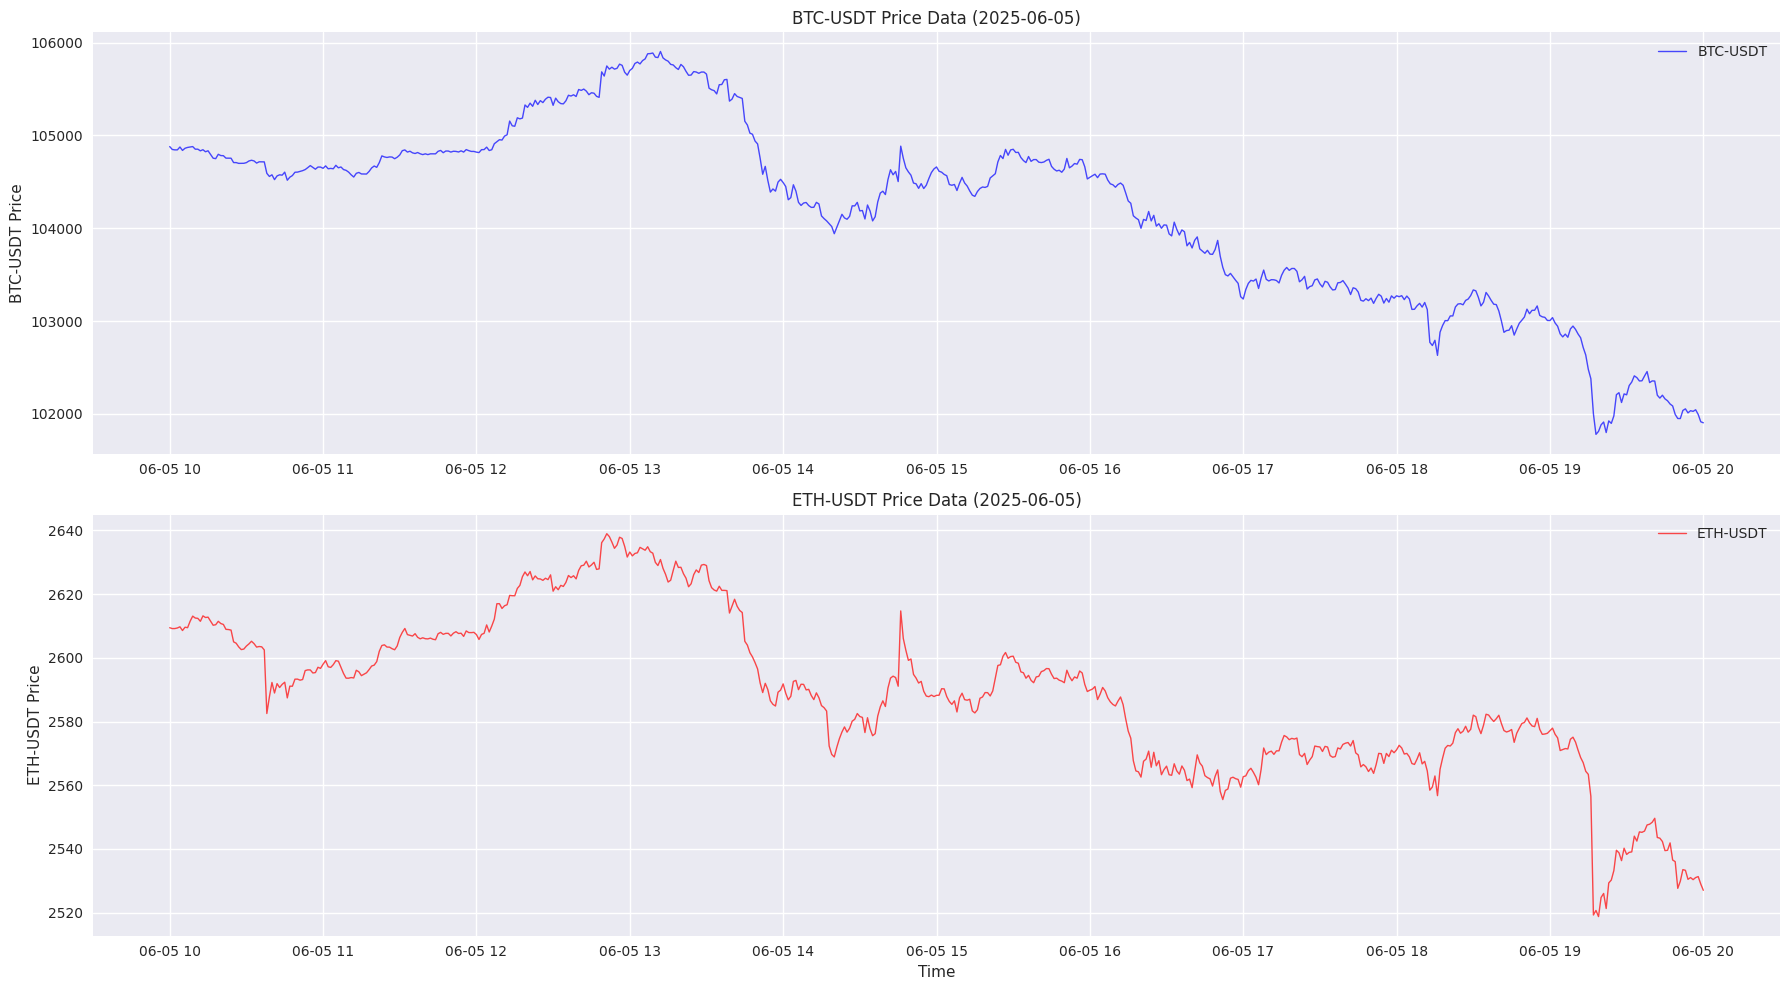

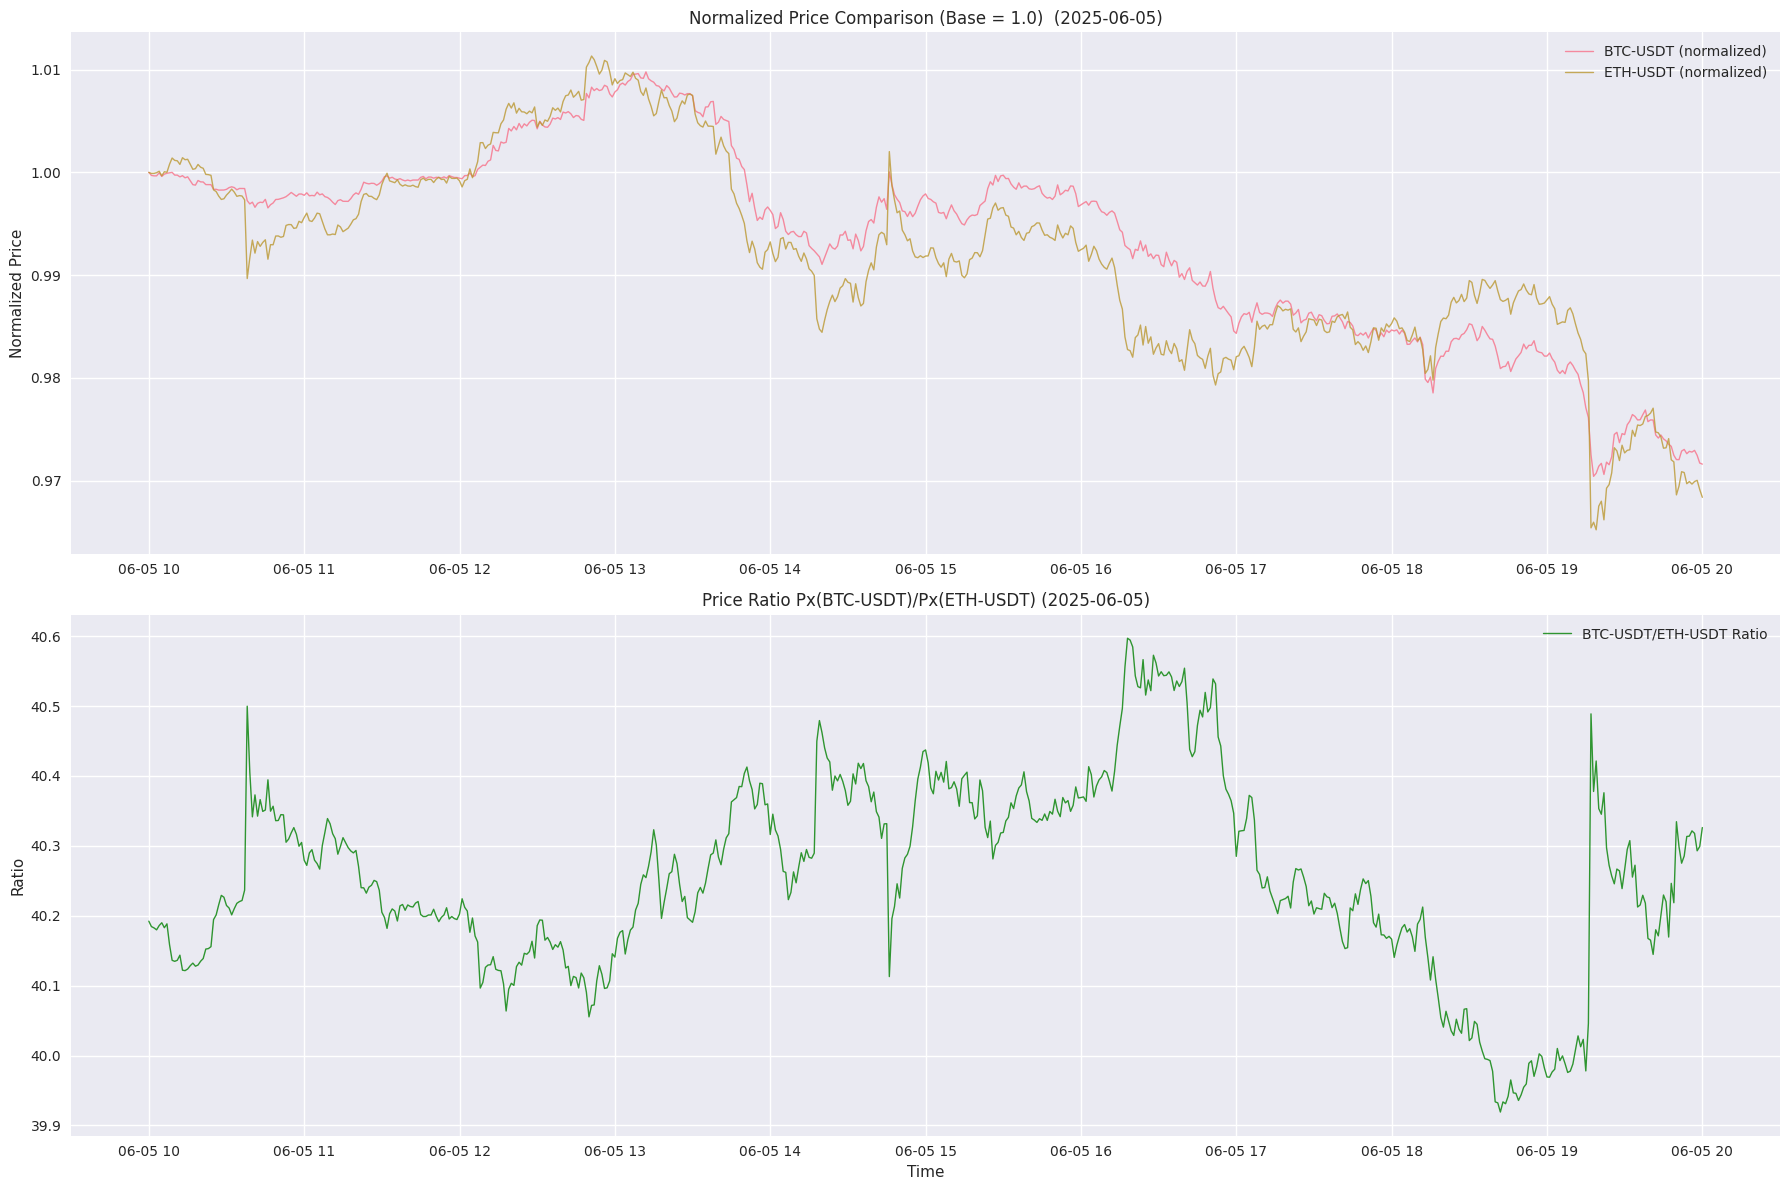


Price Statistics:
  BTC-USDT: Mean=$104195.83, Std=$987.52
  ETH-USDT: Mean=$2588.48, Std=$25.15
  Price Ratio: Mean=40.25, Std=0.14
  Correlation: 0.9376
Running SlidingFit analysis...

=== SLIDING FIT ANALYSIS ===
Processing first 200 iterations for demonstration...
***BTC-USDT & ETH-USDT*** STARTING....
********************************************************************************
Pair BTC-USDT & ETH-USDT (0) IS COINTEGRATED
********************************************************************************
BTC-USDT & ETH-USDT: current offset=482 * Training data length=119 < 120 * Not enough training data. Completing the job.
OPEN_TRADES: 2025-06-05 12:18:00 open_scaled_disequilibrium=np.float64(2.376882701032403)
OPEN TRADES:
                 time action    symbol      price  disequilibrium  scaled_disequilibrium                 pair status
0 2025-06-05 12:18:00    BUY  BTC-USDT  105186.86     -557.925308               2.376883  BTC-USDT & ETH-USDT   OPEN
1 2025-06-05 12:18:00   SE

=== SLIDING FIT INTERACTIVE VISUALIZATION ===
Note: Sliding strategy visualization with interactive plotly charts
Using consistent timeline with 601 timestamps
Timeline range: 2025-06-05 10:00:00 to 2025-06-05 20:00:00

Symbol_A trades:
                  time action    symbol      price  disequilibrium  scaled_disequilibrium                 pair status
0  2025-06-05 12:18:00    BUY  BTC-USDT  105186.86     -557.925308               2.376883  BTC-USDT & ETH-USDT   OPEN
2  2025-06-05 13:01:00   SELL  BTC-USDT  105722.75     -197.135103               0.294001  BTC-USDT & ETH-USDT  CLOSE
4  2025-06-05 13:15:00   SELL  BTC-USDT  105799.92      199.893895               2.534472  BTC-USDT & ETH-USDT   OPEN
6  2025-06-05 13:18:00    BUY  BTC-USDT  105730.43      -65.916792               0.337621  BTC-USDT & ETH-USDT  CLOSE
8  2025-06-05 13:23:00   SELL  BTC-USDT  105648.27      210.776251               2.066777  BTC-USDT & ETH-USDT   OPEN
10 2025-06-05 13:28:00    BUY  BTC-USDT  105683.14     


Chart shows:
- BTC-USDT and ETH-USDT prices normalized to start at 1.0
- BUY signals shown as green triangles pointing up
- SELL signals shown as orange triangles pointing down
- All BUY signals per symbol grouped together, all SELL signals per symbol grouped together
- Hover over markers to see individual trade details (OPEN/CLOSE status)
- Total signals displayed: 28
- BTC-USDT signals: 14
- ETH-USDT signals: 14
PAIRS TRADING BACKTEST SUMMARY

Pair: BTC-USDT & ETH-USDT
Fit Method: SlidingFit
Configuration: crypto
Data file: 20250605.mktdata.ohlcv.db
Trading date: 2025-06-05

Strategy Parameters:
  Training window: 120 minutes
  Open threshold: 2
  Close threshold: 0.5
  Funding per pair: $2000

Sliding Window Analysis:
  Total data points: 601
  Maximum iterations: 481
  Analysis type: Dynamic sliding window

Trading Signals: 28 generated
  Unique trade times: 14
  BUY signals: 14
  SELL signals: 14

First few trading signals:
  1. BUY BTC-USDT @ $105186.86 at 2025-06-05 12:18:00
  

In [12]:
setup()
load_config_from_file()
print_config()
prepare_market_data()
print_strategy_specifics()
visualize_prices()
run_analysis()
visualization()
summary() 
performance_results()


# Conclusions and Next Steps


This notebook demonstrates a comprehensive **SlidingFit pairs trading backtest framework** with advanced interactive visualizations and detailed analysis capabilities.

### Current Implementation Features:

#### SlidingFit Strategy Analysis:
- **Adaptive cointegration modeling** using sliding windows (120-minute default)
- **Dynamic parameter updates** every minute based on market conditions
- **Real-time dis-equilibrium tracking** with configurable open/close thresholds
- **Comprehensive signal generation** with detailed trade tracking and status

#### Advanced Visualization Suite:
- **Interactive Plotly charts** for comprehensive market analysis
- **Normalized price comparison** with overlaid BUY/SELL signals
- **Multi-panel analysis** showing dis-equilibrium, thresholds, and trading timeline
- **Clean legend grouping** with detailed hover tooltips for individual trade information
- **Unified signal visualization** combining OPEN/CLOSE actions per symbol

#### Configuration-Driven Framework:
- **HJSON configuration files** for easy parameter management
- **Multi-asset support** (equity, crypto configurations available)
- **Flexible symbol selection** with automatic data file construction
- **Configurable thresholds** for dis-equilibrium open/close levels
- **Funding and position sizing** parameters

### Key Analysis Capabilities:

1. **Market Data Processing**: Automated loading and preprocessing of OHLCV data
2. **Cointegration Analysis**: Dynamic sliding window cointegration testing
3. **Signal Generation**: Automated BUY/SELL signal generation with precise timing
4. **Performance Tracking**: Comprehensive backtest results with P&L analysis
5. **Interactive Exploration**: Rich visualizations for strategy analysis and debugging

### Current Notebook Usage:

1. **Configure Parameters**: Set `CONFIG_FILE`, `SYMBOL_A`, `SYMBOL_B`, and `TRADING_DATE`
2. **Load Configuration**: Automatic HJSON config loading with path resolution
3. **Process Market Data**: Automated data loading and trading pair creation
4. **Run Analysis**: SlidingFit strategy execution with signal generation
5. **Analyze Results**: Multiple visualization panels and detailed trade analysis
6. **Interactive Exploration**: Plotly charts with hover details and zoom capabilities

### Implemented Visualizations:

- **Raw Price Charts**: Individual symbol price movements over time
- **Normalized Price Comparison**: Base-1.0 normalized prices with trading signals
- **Dis-equilibrium Analysis**: Raw and scaled dis-equilibrium with threshold overlays
- **Trading Signal Timeline**: Comprehensive signal tracking and status visualization
- **Interactive Price Charts**: Symbol-specific price movements with signal overlays

### Recommended Next Steps:

#### Framework Enhancement:
- **Transaction cost modeling** with realistic bid-ask spreads and fees
- **Position sizing algorithms** based on volatility and risk parameters
- **Stop-loss and take-profit** mechanisms for risk management
- **Portfolio-level analysis** across multiple trading pairs

#### Analysis Expansion:
- **Multi-timeframe analysis** (1-min, 5-min, 15-min windows)
- **Cross-validation** on different market periods and conditions
- **Parameter optimization** routines for threshold and window selection
- **Regime detection** for adaptive strategy switching

#### Production Implementation:
- **Real-time data integration** for live trading signal generation
- **Alert system** for threshold breaches and signal generation
- **Performance monitoring** with real-time P&L tracking
- **Risk management dashboard** with position and exposure monitoring

### Strategy Validation:

Test the current implementation with:
- **Different symbol pairs** to validate cointegration relationships
- **Various market conditions** (trending, sideways, volatile periods)
- **Multiple time periods** to assess strategy consistency
- **Threshold sensitivity analysis** to optimize entry/exit parameters
